In [1]:
import pandas as pd

In [15]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


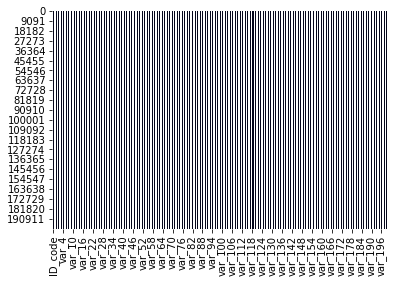

In [4]:
%matplotlib inline
import seaborn as sns
sns.heatmap(train_df.isnull(), cbar=False)

# LightGBM

Inspired in https://www.kaggle.com/gpreda/santander-eda-and-prediction

In [7]:
import lightgbm as lgb

In [8]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

The original code add some feature engineering by adding new features rounded up to 2 digits. However, I skip this in this code.

In [9]:
param = {
        'num_leaves': 6,
        'max_bin': 63,
        'min_data_in_leaf': 45,
        'learning_rate': 0.01,
        'min_sum_hessian_in_leaf': 0.000446,
        'bagging_fraction': 0.55, 
        'bagging_freq': 5, 
        'max_depth': 14,
        'save_binary': True,
        'seed': 31452,
        'feature_fraction_seed': 31415,
        'feature_fraction': 0.51,
        'bagging_seed': 31415,
        'drop_seed': 31415,
        'data_random_seed': 31415,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

In [11]:
from sklearn.model_selection import StratifiedKFold

In [13]:
import numpy as np

In [16]:
# oof stand for 'out-of-fold' exaplained in the 16:40 of this video: https://www.youtube.com/watch?v=V5158Oug4W8

folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=31415)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.861586	valid_1's auc: 0.849244
[2000]	training's auc: 0.889662	valid_1's auc: 0.873735
[3000]	training's auc: 0.903046	valid_1's auc: 0.883614
[4000]	training's auc: 0.910793	valid_1's auc: 0.888464
[5000]	training's auc: 0.915948	valid_1's auc: 0.891605
[6000]	training's auc: 0.91977	valid_1's auc: 0.893314
[7000]	training's auc: 0.922906	valid_1's auc: 0.894577
[8000]	training's auc: 0.925711	valid_1's auc: 0.895398
[9000]	training's auc: 0.928381	valid_1's auc: 0.895723
Early stopping, best iteration is:
[9726]	training's auc: 0.930344	valid_1's auc: 0.896024
Fold 1
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.86181	valid_1's auc: 0.843953
[2000]	training's auc: 0.889758	valid_1's auc: 0.870983
[3000]	training's auc: 0.902508	valid_1's auc: 0.882436
[4000]	training's auc: 0.910195	valid_1's auc: 0.8888
[5000]	training's auc: 0.915529	valid_1's auc

NameError: name 'roc_auc_score' is not defined

In [17]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

--- 

# Another solution using lightGBM

Inspired in https://www.kaggle.com/jesucristo/90-lines-solution-0-901-fast?scriptVersionId=11837989

The same code is found here (**GREAT DISCUSSIONS**): https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#print(os.listdir("../input"))
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from numba import jit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
random_state = 42
np.random.seed(random_state)

@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs); xn = np.vstack(xn)
    ys = np.ones(xs.shape[0]);yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn]); y = np.concatenate([y,ys,yn])
    return x,y
    
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 3
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916507	valid_1's auc: 0.898038
[10000]	training's auc: 0.929001	valid_1's auc: 0.900174
Early stopping, best iteration is:
[9485]	training's auc: 0.927862	valid_1's auc: 0.900228
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916207	valid_1's auc: 0.897906
[10000]	training's auc: 0.928592	valid_1's auc: 0.900295
Early stopping, best iteration is:
[9917]	training's auc: 0.92841	valid_1's auc: 0.900309
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916966	valid_1's auc: 0.898063
[10000]	training's auc: 0.929232	valid_1's auc: 0.900576
Early stopping, best iteration is:
[9988]	training's auc: 0.929206	valid_1's auc: 0.900589
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916136	valid_1's auc: 0.898922
[10000]	training's auc: 0.928527	valid_1's auc: 0.900746
Early stopping, best

In [4]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission.csv", index=False)

## Running again only changing the n_splits to 2.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#print(os.listdir("../input"))
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from numba import jit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
random_state = 42
np.random.seed(random_state)

@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs); xn = np.vstack(xn)
    ys = np.ones(xs.shape[0]);yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn]); y = np.concatenate([y,ys,yn])
    return x,y
    
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits = 2, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 3
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.924877	valid_1's auc: 0.900161
[10000]	training's auc: 0.941439	valid_1's auc: 0.90143
Early stopping, best iteration is:
[8848]	training's auc: 0.938027	valid_1's auc: 0.901466
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.924721	valid_1's auc: 0.899733
[10000]	training's auc: 0.941519	valid_1's auc: 0.900903
Early stopping, best iteration is:
[8488]	training's auc: 0.936978	valid_1's auc: 0.901055
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.924341	valid_1's auc: 0.899815
[10000]	training's auc: 0.941167	valid_1's auc: 0.901071
Early stopping, best iteration is:
[8590]	training's auc: 0.936875	valid_1's auc: 0.901114
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.924756	valid_1's auc: 0.895941
[10000]	training's auc: 0.941552	valid_1's auc: 0.898125
Early stopping, best

In [20]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission_2.csv", index=False)

---
---
---

## Running again only changing the n_splits to 6.

In [21]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
random_state = 42
np.random.seed(random_state)

    
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits = 6, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 3
    p_valid,yp = 0,0 # predictions of validation sample and test sample
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.915997	valid_1's auc: 0.899156
[10000]	training's auc: 0.928067	valid_1's auc: 0.901284
Early stopping, best iteration is:
[11469]	training's auc: 0.931029	valid_1's auc: 0.901421
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.915803	valid_1's auc: 0.898761
[10000]	training's auc: 0.927858	valid_1's auc: 0.900921
[15000]	training's auc: 0.937643	valid_1's auc: 0.900895
Early stopping, best iteration is:
[13859]	training's auc: 0.935496	valid_1's auc: 0.901053
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916062	valid_1's auc: 0.898537
[10000]	training's auc: 0.928071	valid_1's auc: 0.900891
Early stopping, best iteration is:
[10333]	training's auc: 0.928757	valid_1's auc: 0.900922
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.915789	valid_1's auc: 0.898104
[10000]	training

In [22]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission_6.csv", index=False)

## Back to n_splits to 5, but changing num_leaves to 14.

In [23]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
random_state = 42
np.random.seed(random_state)

    
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 14,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 3
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000, valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.917837	valid_1's auc: 0.89825
[10000]	training's auc: 0.930895	valid_1's auc: 0.900136
Early stopping, best iteration is:
[9514]	training's auc: 0.929754	valid_1's auc: 0.900232
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.917445	valid_1's auc: 0.8982
[10000]	training's auc: 0.930395	valid_1's auc: 0.900304
Early stopping, best iteration is:
[9917]	training's auc: 0.930198	valid_1's auc: 0.900322
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.918208	valid_1's auc: 0.898228
[10000]	training's auc: 0.931092	valid_1's auc: 0.900459
Early stopping, best iteration is:
[11303]	training's auc: 0.933935	valid_1's auc: 0.900501
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.917391	valid_1's auc: 0.899283
[10000]	training's auc: 0.930397	valid_1's auc: 0.900941
Early stopping, best 

In [24]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission_num_leaves_14.csv", index=False)

# Squaring the values:

In [34]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [35]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [36]:
features_sqr = ['sqr_' + i for i in features]

In [38]:
train_df[features_sqr] = train_df[features] ** 2
test_df[features_sqr]  = test_df[features] ** 2

In [40]:
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 3
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.943597	valid_1's auc: 0.892644
[10000]	training's auc: 0.954729	valid_1's auc: 0.897314
[15000]	training's auc: 0.96287	valid_1's auc: 0.897498
Early stopping, best iteration is:
[12855]	training's auc: 0.959514	valid_1's auc: 0.897548
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.943356	valid_1's auc: 0.892663
[10000]	training's auc: 0.954521	valid_1's auc: 0.897188
[15000]	training's auc: 0.962604	valid_1's auc: 0.897451
Early stopping, best iteration is:
[14139]	training's auc: 0.961285	valid_1's auc: 0.897526
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.943368	valid_1's auc: 0.892885
[10000]	training's auc: 0.954434	valid_1's auc: 0.897384
[15000]	training's auc: 0.96259	valid_1's auc: 0.897661
Early stopping, best iteration is:
[12950]	training's auc: 0.959399	valid_1's auc: 0.897729
Training until validatio

In [41]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission_squaring_values.csv", index=False)

# Adding values that rounded to 2 decimal digits:

In [43]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [47]:
features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
features_round = ['sqr_' + i for i in features]

In [48]:
train_df[features_round] = round(train_df[features], 2)
test_df[features_round]  = round(test_df[features], 2)

In [49]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,sqr_var_190,sqr_var_191,sqr_var_192,sqr_var_193,sqr_var_194,sqr_var_195,sqr_var_196,sqr_var_197,sqr_var_198,sqr_var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.44,3.96,3.14,1.69,18.52,-2.40,7.88,8.56,12.78,-1.09
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.64,7.72,2.58,10.95,15.43,2.03,8.13,8.79,18.36,1.95
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.91,9.79,1.67,1.69,21.60,3.14,-6.52,8.27,14.72,0.40
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.47,4.74,0.72,1.42,23.03,-1.27,-2.93,10.29,17.97,-9.00
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.49,9.52,-0.15,9.19,13.29,-1.51,3.93,9.50,18.00,-8.81


In [50]:
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 3
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.949889	valid_1's auc: 0.894929
[10000]	training's auc: 0.95977	valid_1's auc: 0.89985
[15000]	training's auc: 0.966847	valid_1's auc: 0.900296
[20000]	training's auc: 0.9731	valid_1's auc: 0.900122
Early stopping, best iteration is:
[17979]	training's auc: 0.970686	valid_1's auc: 0.900337
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.950377	valid_1's auc: 0.895181
[10000]	training's auc: 0.960195	valid_1's auc: 0.900046
[15000]	training's auc: 0.967281	valid_1's auc: 0.900471
Early stopping, best iteration is:
[15209]	training's auc: 0.967553	valid_1's auc: 0.900493
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.950325	valid_1's auc: 0.895224
[10000]	training's auc: 0.960114	valid_1's auc: 0.900192
[15000]	training's auc: 0.967195	valid_1's auc: 0.900565
Early stopping, best iteration is:
[16157]	training's auc: 0.

In [51]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission_round_values_to_2_decimals.csv", index=False)

# Changing only N = 6

In [52]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
random_state = 42
np.random.seed(random_state)

@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs); xn = np.vstack(xn)
    ys = np.ones(xs.shape[0]);yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn]); y = np.concatenate([y,ys,yn])
    return x,y
    
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.05,
    "min_data_in_leaf": 80, "min_sum_heassian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 6
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916507	valid_1's auc: 0.898038
[10000]	training's auc: 0.929001	valid_1's auc: 0.900174
Early stopping, best iteration is:
[9485]	training's auc: 0.927862	valid_1's auc: 0.900228
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916207	valid_1's auc: 0.897906
[10000]	training's auc: 0.928592	valid_1's auc: 0.900295
Early stopping, best iteration is:
[9917]	training's auc: 0.92841	valid_1's auc: 0.900309
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916966	valid_1's auc: 0.898063
[10000]	training's auc: 0.929232	valid_1's auc: 0.900576
Early stopping, best iteration is:
[9988]	training's auc: 0.929206	valid_1's auc: 0.900589
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.916996	valid_1's auc: 0.898022
[10000]	training's auc: 0.929323	valid_1's auc: 0.900499
Early stopping, best

Early stopping, best iteration is:
[12024]	training's auc: 0.933634	valid_1's auc: 0.897375
Mean auc: 0.901654402, std: 0.003016864. All auc: 0.901579067.


In [53]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission_N_equals_to_6.csv", index=False)

# Increasing feature_fraction to 0.075 (and fixing min_sum_hessian_in_leaf name!!!)

In [54]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
random_state = 42
np.random.seed(random_state)

@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs); xn = np.vstack(xn)
    ys = np.ones(xs.shape[0]);yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn]); y = np.concatenate([y,ys,yn])
    return x,y
    
params = {
    "objective" : "binary", "metric" : "auc", "boosting": 'gbdt', "max_depth" : -1, "num_leaves" : 13,
    "learning_rate" : 0.01, "bagging_freq": 5, "bagging_fraction" : 0.4, "feature_fraction" : 0.075,
    "min_data_in_leaf": 80, "min_sum_hessian_in_leaf": 10, "tree_learner": "serial", "boost_from_average": "false",
    "bagging_seed" : random_state, "verbosity" : 1, "seed": random_state
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []

features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 3
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 5000,evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    predictions['fold{}'.format(fold+1)] = yp/N
    
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.917613	valid_1's auc: 0.898051
[10000]	training's auc: 0.930426	valid_1's auc: 0.900214
Early stopping, best iteration is:
[9161]	training's auc: 0.928514	valid_1's auc: 0.900286
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.917372	valid_1's auc: 0.897952
[10000]	training's auc: 0.930024	valid_1's auc: 0.900062
Early stopping, best iteration is:
[9209]	training's auc: 0.928256	valid_1's auc: 0.900168
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.917943	valid_1's auc: 0.897666
[10000]	training's auc: 0.93062	valid_1's auc: 0.900065
[15000]	training's auc: 0.940892	valid_1's auc: 0.8999
Early stopping, best iteration is:
[12713]	training's auc: 0.936337	valid_1's auc: 0.900147
Training until validation scores don't improve for 3000 rounds.
[5000]	training's auc: 0.917173	valid_1's auc: 0.898744
[10000]	training's au

In [55]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
submission = pd.DataFrame({"ID_code":test_df["ID_code"].values})
submission["target"] = predictions['target']
submission.to_csv("lgb_submission_feature_fraction_0075.csv", index=False)